# Simple Self Contained Model of the Funcspec Project

## Imports

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot


## Data

### Datasets

In [2]:
from community.data.datasets import get_datasets
from community.common.utils import plot_grid


In [60]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
n_classes = 4
multi_loaders, double_loaders_dig, double_loaders_letters, single_loaders, letters = get_datasets('../../data', batch_size, use_cuda, fix_asym=True, n_classes=n_classes, split_classes=True)
loaders = double_loaders_letters


### Task

In [51]:
def parity_task(target) : 

    parity = 1 - target.sum(-1)%2
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    return parity_target

def temporal_data(data, n_steps=2, device=torch.device('cuda'), flatten=True) :

    data = data.transpose(0, 1)
    if flatten : data = data.flatten(start_dim=2)
    return torch.stack([data for _ in range(n_steps)]).to(device)

def get_data(temporal=False, task=False, flatten=True) : 
    data, target = next(iter(loaders[0]))
    if temporal : data = temporal_data(data, device=device, flatten=flatten)
    if task : target = parity_task(target)

    return data.to(device), target.to(device)


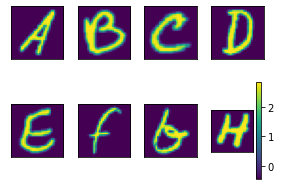

In [61]:
class_split = ([d.truncate_values for d in loaders[0].dataset.datasets])
idxs = [[(d.targets == c).float().argmax() for c in range(n_classes)] for d in loaders[0].dataset.datasets]
datas = [[d[i][0] for i in idx] for d, idx in zip(loaders[0].dataset.datasets, idxs)]
plot_grid(datas, figsize=(n_classes, 3))


In [69]:
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])
all_targets = get_all_targets()
uniques, counts = all_targets.unique(dim=0, return_counts=True)
uniques, counts, counts.shape, all_targets.shape

(tensor([[0, 2],
         [0, 3],
         [1, 0],
         [1, 3],
         [2, 0],
         [2, 1],
         [3, 1],
         [3, 2]]),
 tensor([1084, 1086, 1074, 1106, 1090, 1092, 1076, 1096]),
 torch.Size([8]),
 torch.Size([8704, 2]))

In [71]:
task_t = parity_task(all_targets)
task_t.unique(dim=0, return_counts=True), (all_targets.sum(-1) % 2).unique(return_counts=True)

((tensor([0, 1, 2, 3]), tensor([2158, 2198, 2186, 2162])),
 (tensor([0, 1]), tensor([4356, 4348])))

## Models

In [102]:
class Agent(nn.Module) : 

    def __init__(self, dims) : 
        super().__init__()
        self.cell = nn.RNN(dims[0], dims[1], 1, bias=False, batch_first=False)
        self.readout = nn.Linear(dims[1], dims[2], bias=False)

    def forward(self, input, state=None, connections=0) : 

        if len(input.shape ) < 3 : 
            input = input.unsqueeze(0)

        if state is None : 
            out, h = self.cell(input)
        else : 
            h = state + connections
            out, h = self.cell(input, h)

        out = self.readout(out[0])

        return out, h

class Connection(nn.Linear) : 
    def __init__(self, dims, p, binary=False) : 

        super().__init__(dims[0], dims[1], bias=False)

        self.sparsity = p
        n_in, n_out = dims
        self.nb_non_zero = int(p*n_in*n_out)
        w_mask = np.zeros((n_in, n_out),dtype=bool)
        ind_in, ind_out = np.unravel_index(np.random.choice(np.arange(n_in*n_out), self.nb_non_zero, replace=False), (n_in, n_out))
        w_mask[ind_in,ind_out] = True
        w_mask = torch.tensor(w_mask)
        self.register_buffer('w_mask', w_mask)

        assert w_mask.sum() == self.nb_non_zero, f'Number of nonzero connection is {w_mask.sum()}, expected {self.nb_non_zero}'

    def forward(self, input) : 
        out = F.linear(input, self.weight*self.w_mask)
        assert (out != 0).float().sum(-1).max() <= self.nb_non_zero, f'{(out != 0).float().sum(-1).max()} non zero connections !'

        return out

class Ensemble(nn.Module) : 
    def __init__(self, dims, p) : 

        super().__init__()
        self.n_in, self.n_hid, self.n_out = dims
        self.agents = nn.ModuleList([Agent(dims) for _ in range(2)])[::-1]
        self.connections = nn.ModuleList([Connection([dims[1]]*2, p) for _ in range(2)])

    def forward(self, input): 

        states, outputs, conns = [None for _ in range(2)], [[] for _ in range(2)], [None for _ in range(2)]
        
        for t, t_input in enumerate(input) :
            for ag, agent in enumerate(self.agents) : 
                
                ag_input = t_input[ag]
                
                if t>0 : 
                    input_connect = self.connections[1-ag](states[1-ag])
                else : 
                    input_connect = 0
                
                out, h = agent(ag_input, states[ag], input_connect)


                states[ag] = h
                outputs[ag].append(out)
                conns[ag] = input_connect

        outputs = torch.stack([torch.stack(o) for o in outputs], 1)
        states = torch.stack(states, 1)[0]
        conns = torch.stack(conns, 1)[0]

        #print((outputs[-1][1] == outputs[-1][1]).all())

        return outputs, states, conns
     

## Decisions


In [103]:
def get_decision(outputs, decision_params, target=None) : 
    temporal_decision, agent_decision = decision_params

    if temporal_decision == 'last' : 
        outputs = outputs[-1]

    else : 
        raise NotImplementedError

    try : 
        deciding_ags = int(agent_decision)
        outputs = outputs[deciding_ags]
        deciding_ags = torch.ones(outputs.shape[0])*deciding_ags
        return outputs, deciding_ags

    except ValueError : 

        if agent_decision == 'loss' :
            assert target is not None, 'Provide target for min loss decision'
            loss, min_idxs = torch.stack([F.cross_entropy(out, target, reduction='none') for out in outputs]).min(0)
            min_idxs = min_idxs.unsqueeze(-1).expand_as(outputs[0])
            outputs = torch.where(~min_idxs.bool(), outputs[0], outputs[1])
            deciding_ags = min_idxs
            return outputs, deciding_ags

        else : 
            raise NotImplementedError

def check_grad(model, task_id = '0') : 
    for n, p in model.named_parameters() : 
        if 'k_params' in n or 'all_scores' in n : 
            if task_id in n : 
                return check_ind_grad(n, p)
        else : 
            check_ind_grad(n, p)

def check_ind_grad(n, p) : 
    if p.grad is not None : 
        if (p.grad == 0).all() : 
            ''
            print(f'{n}, Zero Grad')
        #else : print(f'{n} : {p.grad}')
    elif p.requires_grad : 
        ''
        print(f'{n}, None Grad')

## Init

In [117]:
dims = [784, 50, n_classes]
sparsity = 1 * 1/dims[1]**2

community = Ensemble(dims, sparsity).to(device)
optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)
#list(dict(community.named_parameters()).keys())

In [99]:
data, target = get_data()
data = temporal_data(data)
out, states, conns = community(data)

In [338]:
make_dot(out[-1][1], dict(community.named_parameters())).render('graph')

'graph.pdf'

## Training

In [118]:
n_epochs = 10

decision_params = ('last', '1')
pbar = tqdm_n(range(n_epochs))
descs = np.full((2), '', dtype=object)
check_gradients = False

train_loader, test_loader = loaders
subset = len(train_loader)

for epoch in pbar : 
    # Training

    for batch_idx, ((data, target), n) in enumerate(zip(train_loader, range(subset) )) : 

        data, target = temporal_data(data, device=device), parity_task(target).to(device)

        optimizer.zero_grad()

        outputs, states, conns = community(data)
        #print((outputs[-1][0] == outputs[-1][1]).all())
        output, deciding_ags = get_decision(outputs, decision_params)

        loss = F.cross_entropy(output, target)
        loss.backward()

        if check_gradients : 
            zero_grads = np.array([((p.grad == 0).all()).cpu().data.item() for p in community.parameters() if p.grad is not None])
            none_grads = np.array([p.grad is None for p in community.parameters()])
            zero_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[~none_grads][zero_grads]
            none_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[none_grads]

            print(f'Zero params : {zero_params}')
            #print(f'None Params : {none_params}')
            
        optimizer.step()

        pred = output.argmax(dim=-1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().cpu().data.item()
        acc = (correct / target.numel())

        descs[0] = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Accuracy: {}%'.format(
                        epoch, batch_idx * train_loader.batch_size, len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item(),
                        (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                        )

        pbar.set_description((descs.sum()))


  0%|          | 0/10 [00:00<?, ?it/s]

## Analysis


### Connections

array([[-59.435604 ,  64.83127  , -62.18497  ,  64.261154 ],
       [  7.4035916,   7.464872 ,  -3.7556229,   7.5042534]],
      dtype=float32)

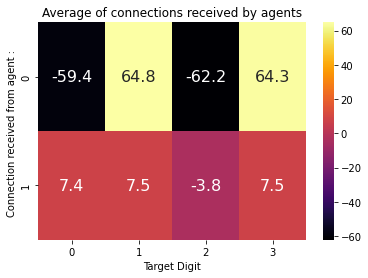

In [116]:
sums = []
nonzero_idxs = [c.w_mask.nonzero()[:, 0] for c in community.connections]
for data, target in loaders[1] : 
    data = temporal_data(data)
    out, states, conns = community(data.to(device))
    #conns[-1][0].count_nonzero(dim=0)
    #torch.stack([conns[-1][i].count_nonzero(dim=0).max() for i in range(2)])
    #sums.append(torch.tensor([[conns[-1][i][target[:, i] == t].sum() for t in range(4)] for i in range(2)]))
    sums.append(torch.stack([torch.stack([conns[i][target[:, 1-i] == t][:, nonzero_idxs[1-i]].sum(0) for t in range(n_classes)]) for i in range(2)]))

sums = torch.stack(sums).cpu().data.numpy().mean(0)[..., 0]
ax = sns.heatmap(sums, cmap="inferno", annot=sums.round(1).astype(str), annot_kws={'fontsize': 16}, fmt='s')
ax.set_xlabel('Target Digit')
ax.set_ylabel('Connection received by agent : ')
ax.set_title('Average of connections received by agents')


In [112]:
sums.astype('str')

array([['-59.435604', '64.83127', '-62.18497', '64.261154'],
       ['7.4035916', '7.464872', '-3.7556229', '7.5042534']], dtype='<U32')

In [108]:
sums.shape

(2, 4, 1)

 ### Decisions

In [ ]:
from community.common.decision import get_decision

/tmp/ipykernel_4929/1109753099.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = target.eq(torch.tensor(t)).all(axis=1)


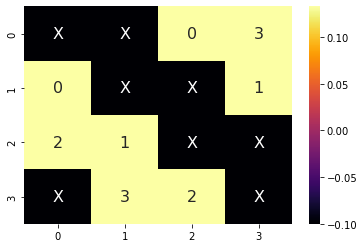

In [95]:
if 'all_targets' not in globals() : 
    all_targets = get_all_targets()

uniques = all_targets.unique(dim=0)
decision_means = torch.zeros(len(uniques))
for data, target in loaders[1] : 
    data, t_target = temporal_data(data).to(device), parity_task(target.to(device))
    output, *_ = community(data)
    output, decision_ags = get_decision(output, decision_params, target=t_target)

    for i, t in enumerate(uniques) : 
        mask = target.eq(torch.tensor(t)).all(axis=1)
        decision_means[i] += decision_ags[mask].float().cpu().mean()/mask.numel()

digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
decisions = np.zeros((n_classes, n_classes))
targets = np.zeros((n_classes, n_classes), dtype=object)
for d1 in range(n_classes) : 
    for d2 in range(n_classes) : 
        if digits_in(d1, d2) : 
            decisions[d1, d2] = decision_means[digits_idx(d1, d2)]
            targets[d1, d2] = str(parity_task(uniques)[digits_idx(d1, d2)].cpu().data.item())
        else : 
            decisions[d1, d2] = -0.1
            targets[d1, d2] = 'X'
ax = sns.heatmap(decisions, cmap="inferno", annot=targets, annot_kws={'fontsize': 16}, fmt='s')
try : 
    ax.set_title(f'Overall decision = {results["deciding_agents"].mean():.3f}')
except NameError : 
    'continue' 
plt.show()